# Recipe for computing the membership function used in the clutter classification

Daniel Sanchez-Rivas<sup>1</sup> and Miguel A. Rico-Ramirez<sup>1</sup>

<sup>1</sup>Department of Civil Engineering, University of Bristol, Bristol, BS8 1TR, United Kingdom

**This notebook describes the process to compute membership functions used in the clutter classification methodology.**

We'll use raw C-band radar data collected by the operational UK Met Office radar network.

UK Met Office C-band rain radar dual-polarisation products are available at http://catalogue.ceda.ac.uk/uuid/82adec1f896af6169112d09cc1174499 (Met Office, 2003)

### Import relevant packages

In [1]:
import pickle
import os
import numpy as np

import towerpy as tp
import cartopy.crs as ccrs

%matplotlib notebook


You are using the Towerpy framework, an open source library for
working with polarimetric weather radar data.

If you find our work useful for your research, please consider citing our
following publication:





### Define working directory and file name

For this example, we'll use data collected at the Jersey radar site; *augzdr* stands for polarimetric data, *lp* for long-pulse and *el0* refers to collected at 0.5&deg; elevation angle.

In [2]:
rsite = 'jersey'
fdir = f'../../../datasets/{rsite}/y2020/lpel0/'
fname = (f'metoffice-c-band-rain-radar_{rsite}_202010030735_raw-dual-polar-'
         + 'augzdr-lp-el0.dat')
wdir = '../datasets/mfs_mclass/'

### Use Towerpy to read in the raw radar variables.

The **Rad_scan class** initialises a radar object. 

Within the **ukmo module**, the *ppi_ukmoraw* function provides an interface to read the current binary format used by the MO to store the radar data.

Note that the argument *exclude_vars* was used to discard the 'W [m/s]', 'SQI [-]' and 'CI [dB]'] variables, as they  will not be used at this stage.

<IPython.core.display.Javascript object>


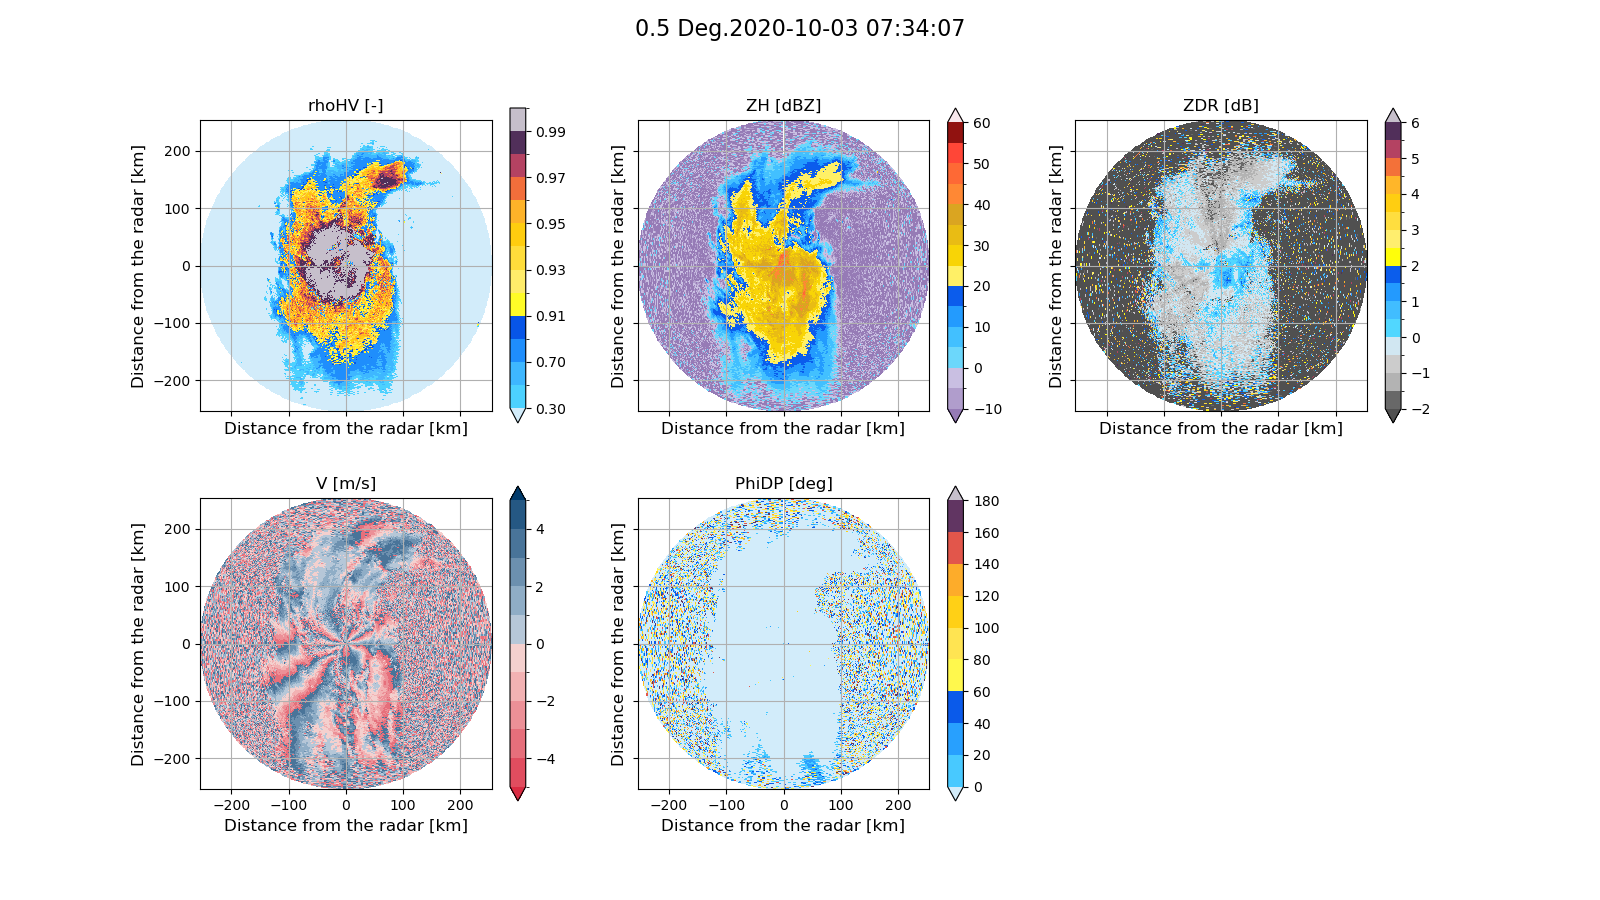

In [6]:
rdata = tp.io.ukmo.Rad_scan(fdir+fname, rsite)
rdata.ppi_ukmoraw(exclude_vars=['W [m/s]', 'SQI [-]', 'CI [dB]'])
rdata.ppi_ukmogeoref()

tp.datavis.rad_display.plot_setppi(rdata.georef, rdata.params, rdata.vars)

### Computation of the Signal-to-Noise-Ratio

We use the *signalnoiseratio* function to compute the Signal-to-Noise-Ratio (SNR) (in dB) and discard data using a reference noise value equal to 35 dB.
This value had been checked at all the UK Met office radar sites (valid only for long-pulse scans) and proved effective in removing noise within the scans.

The *data2correct* argument copies the original data and generates a new dictionary containing radar variables but SNR filtered.

In [4]:
rsnr = tp.eclass.snr.SNR_Classif(rdata)
rsnr.signalnoiseratio(rdata.georef, rdata.params, rdata.vars, min_snr=35,
                      data2correct=rdata.vars)

### The **rad_interactive** module

This module helps explore the PPI scans. For instance, the **user can store the coordinates of the current position of the mouse pointer by pressing a number (0-9)**.

We use the **rad_interactive** module to classify pixels manually (and empirically). For this case, we use 0 for meteorological echoes and 5  for non-meteorological ones, in accordance with the *clutter_id* function.

<font color='red'> We recommend using the IDE Spyder to do this.</font>

<IPython.core.display.Javascript object>


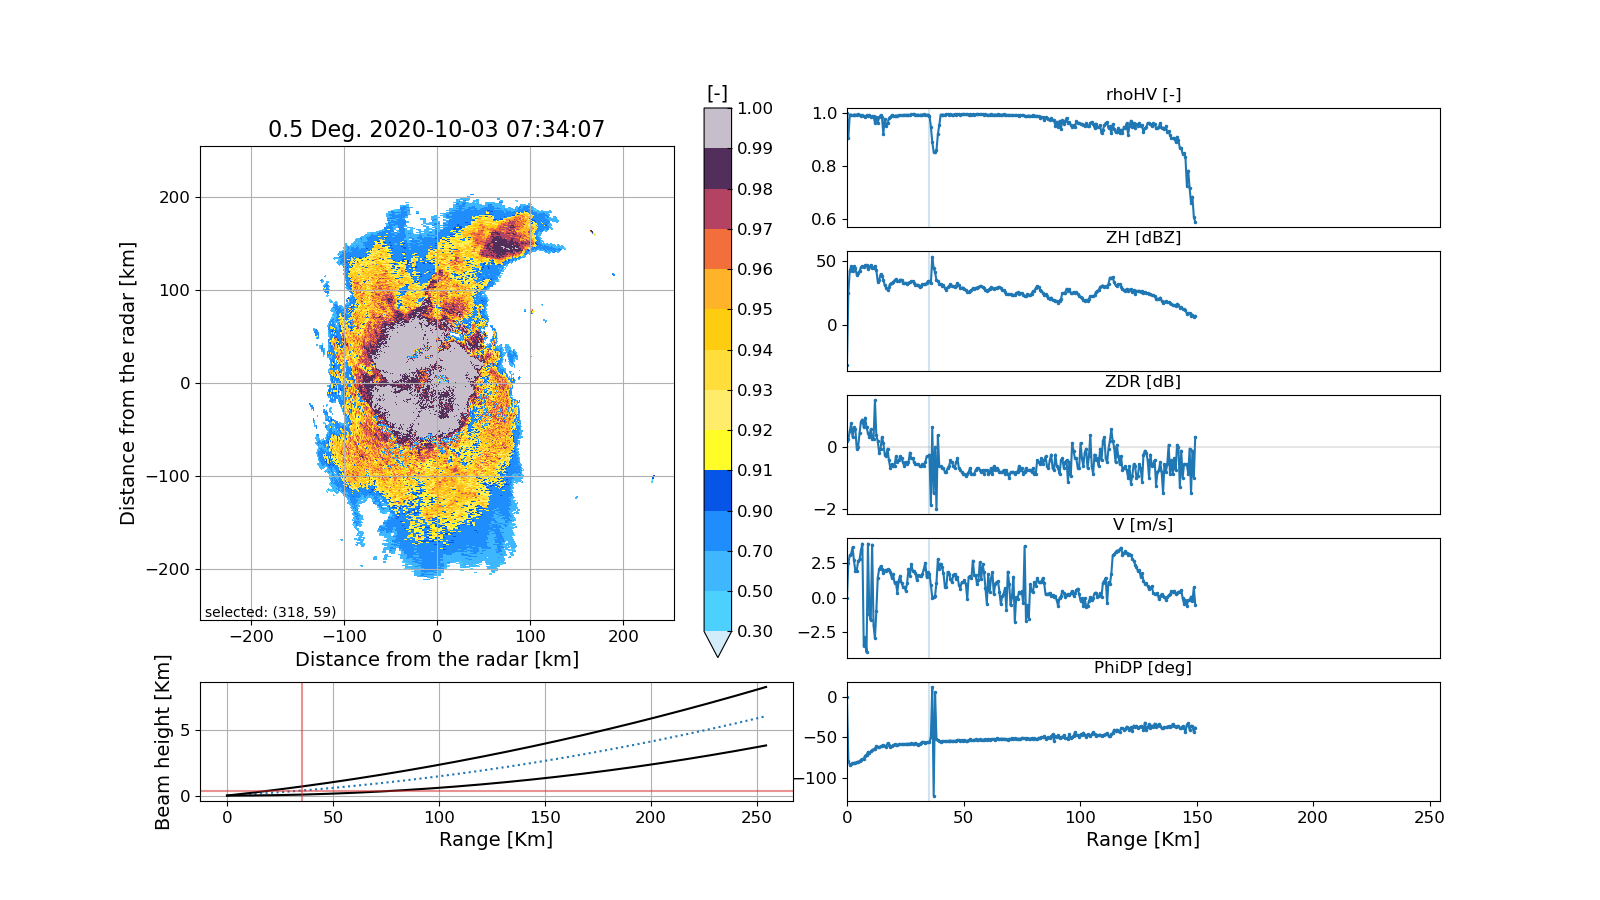


 
 
  Right-click on a pixel within the PPI to select its 
  azimuth or use the n and m keys to browse through the next 
  and previous azimuth.                                      
  Radial profiles of polarimetric variables will be shown at 
  the axes on the right.                                     
  Press a number (0-9) to store the coordinates and value    
  of the current position of the mouse pointer.              
  These coordinate can be retrieved at                       
  ppiexplorer.clickcoords                                    


In [9]:
tp.datavis.rad_interactive.ppi_base(rdata.georef, rdata.params, rsnr.vars,
                                    var2plot='rhoHV [-]')
ppiexplorer = tp.datavis.rad_interactive.PPI_Int()

<font color='blue'> The radial profiles help identify potential clutter pixels, as **these echoes have distinctive values of $Z_H$, $Z_{DR}$, $\rho_{HV}$ and $\Phi_{DP}$!!!**</font> 

Next, we use the *savearray2binfile* function provided in this class to save the coordinates and classification code of the pixels.

By default, this module stores the file name and saves it appending the extension *\*.tpmc* (**t**ower**p**y **m**anual **c**lassification). Note that we store the min_snr used in the *signalnoiseratio* function and the radar site name as well.

In [10]:
# ppiexplorer.savearray2binfile(file_name=rdata.file_name, dir2save=wdir,
#                               min_snr=rsnr.min_snr, rsite=rsite)

## <font color='purple'> We will only use one file in this example, but users must repeat this task using plenty of PPI scans to gather as many pixels as possible to generate more accurate membership functions!</font>

Next, we list the binary files generated by the *rad_interactive* module. 

In [4]:
radfiles = [wdir+f for n, f in enumerate(sorted(os.listdir(wdir)))
          if f.endswith('.tpmc')]

<font color='red'>**Remember that the *\*.tpmc* files contain the coordinates and classID of the pixels, not their values.**</font>

Thus, we implement a loop to extract the values of the radar variables (*ppi_ukmoraw*), discard noise (*signalnoiseratio*) and compute their textures (*compute_texture*):

In [6]:
rvars_txt = []

# Define the classification identification number and types:
echoesID = {'precipi': 0, 'clutter': 5}

for rf in radfiles:
    with open(rf, 'rb') as handle:
        coordobj = pickle.load(handle)
        rdata = tp.io.ukmo.Rad_scan(coordobj['file_name'], coordobj['rsite'])
        rdata.ppi_ukmoraw(exclude_vars=['W [m/s]', 'SQI [-]', 'CI [dB]'])
        rsnr = tp.eclass.snr.SNR_Classif(rdata)
        rsnr.signalnoiseratio(rdata.georef, rdata.params, rdata.vars,
                              min_snr=coordobj['min_snr'],
                              data2correct=rdata.vars)
        rvars = tp.utils.radutilities.compute_texture(coordobj['coord_list'],
                                                      rsnr.vars)
        rvars_txt.append(rvars)

# %%
# tp.datavis.rad_display.plot_ppi(rdata.georef, rdata.params, coordobj)

## MFS files description

**It important to mention that the *clutter_id* function requires a certain type of file names and format to run.**

1. The MFS must be in  two-columns-plain-text files. Each column contain 51 element, where the first column contains the histogram bin edges and the second one the values of the histogram.
2. The elements are floating point numbers in scientific notation.
3. The name convention is as follow:
    - **cal_mf_VVVV_TTTTTT.dat**
    
        where *VVVV* refers to the variable name and *TTTTTT* to the echoe type, as defined in *echoesID*.

To automatise the creation of the MFS, we create a *dictionary* containing the radar variable name as key and 2-element list/tuple where the first element specify if the variable will be used (Note that only LDR is set to False) and the second one define the tag to use in the file name (*VVVV* element).

In [20]:
varord = {'ZH [dBZ]': [True, 'ZHH'],
          'ZDR [dB]': [True, 'ZDR'],
          'rhoHV [-]': [True, 'Rhv'],
          'PhiDP [deg]': [True, 'Pdp'],
          'V [m/s]': [True, 'Vel'],
          'sZH [dBZ]': [True, 'sZhh'],
          'sZDR [dB]': [True, 'sZdr'],
          'srhoHV [-]': [True, 'sRhv'],
          'sPhiDP [deg]': [True, 'sPdp'],
          'sV [m/s]': [True, 'sVel'],
          'LDR [dB]': [False, 'LDR'],
         }

### We do a bit of processing of the data.

We stack the variables pixel values from the listed files:

In [21]:
dvars = {kclass: {kvar: np.hstack([i[kclass][kvar] for i in rvars_txt
                                   if np.array(i[kclass][kvar]).size != 0])
                  for kvar, vvar in varord.items() if vvar[0] is True}
         for kclass in echoesID.keys()}

Then, we calculate the histograms using the np.histogram function:

In [22]:
hists = {kclass: {kvar: list(np.histogram(dvars[kclass][kvar][~np.isnan(dvars[kclass][kvar])],
                                          bins=51, density=True))
                  for kvar, vvar in varord.items() if vvar[0] is True}
         for kclass in echoesID.keys()}

We do some processing to filter unwanted values within the histograms:

In [23]:
for kclass in echoesID.keys():
    for kvar, vvar in varord.items():
        if vvar[0] is True:
            hists[kclass][kvar][0][hists[kclass][kvar][0] == 0] = np.ma.masked_equal(hists[kclass][kvar][0], 0.0, copy=False).min()
            hists[kclass][kvar][1] = hists[kclass][kvar][1][:-1]

We use the *np.savetxt* to store the data in *\.dat* files.

In [24]:
mfs = {f'{wdir}cal_mf_{vvar[1]}_{kclass}.dat':
       np.roll(np.array(hists[kclass][kvar]).T, 1, axis=1)
       for kvar, vvar in varord.items() if vvar[0] is True
       for kclass in echoesID.keys()}

# mfs = [np.savetxt(k, v, fmt='%.7e') for k, v in mfs.items()]

### Let's plot the MFS:

<IPython.core.display.Javascript object>


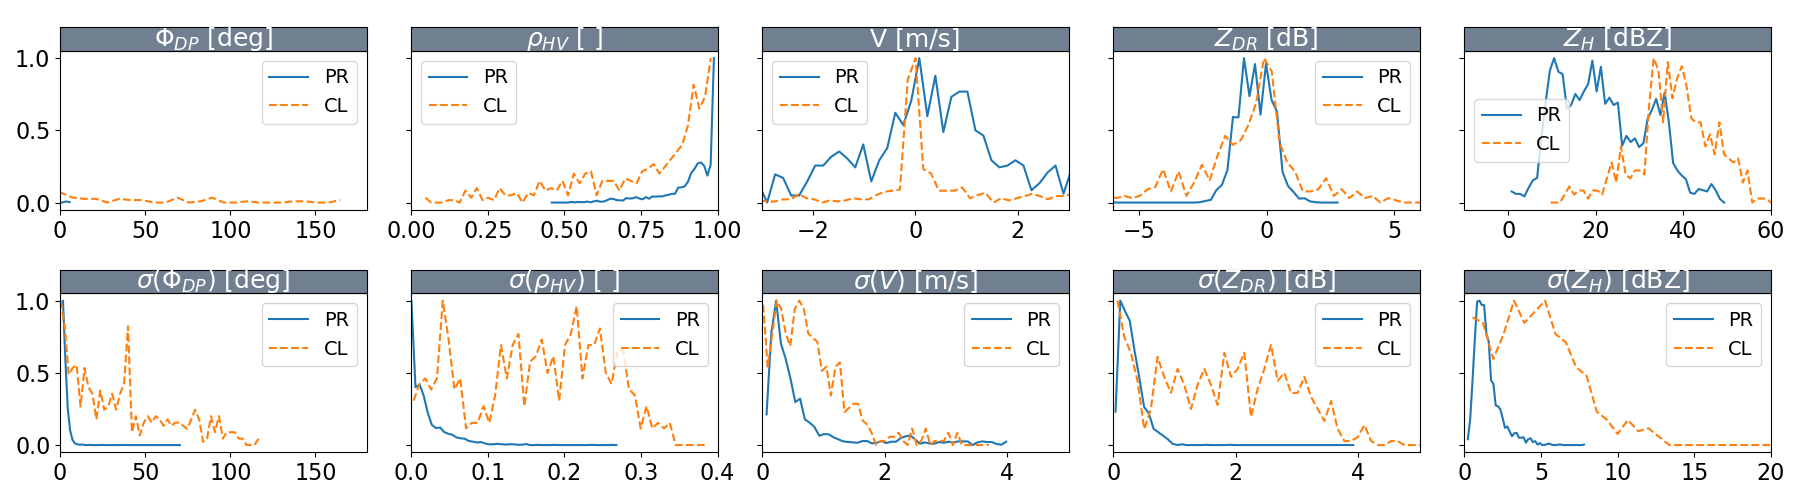

In [25]:
tp.datavis.rad_display.plot_mfs(wdir)

## Final remarks

It can be seen that using one file only is not enough to capture the polarimetric fingerprints of clutter-echoes thoroughly.

*However, this is the first step. By selecting many more pixels related to different hydrometer types taken during either convective or stratiform rain events, we can increase the reliability of the membership functions!*

See for instance the MFS created from C-band radar data:

<IPython.core.display.Javascript object>


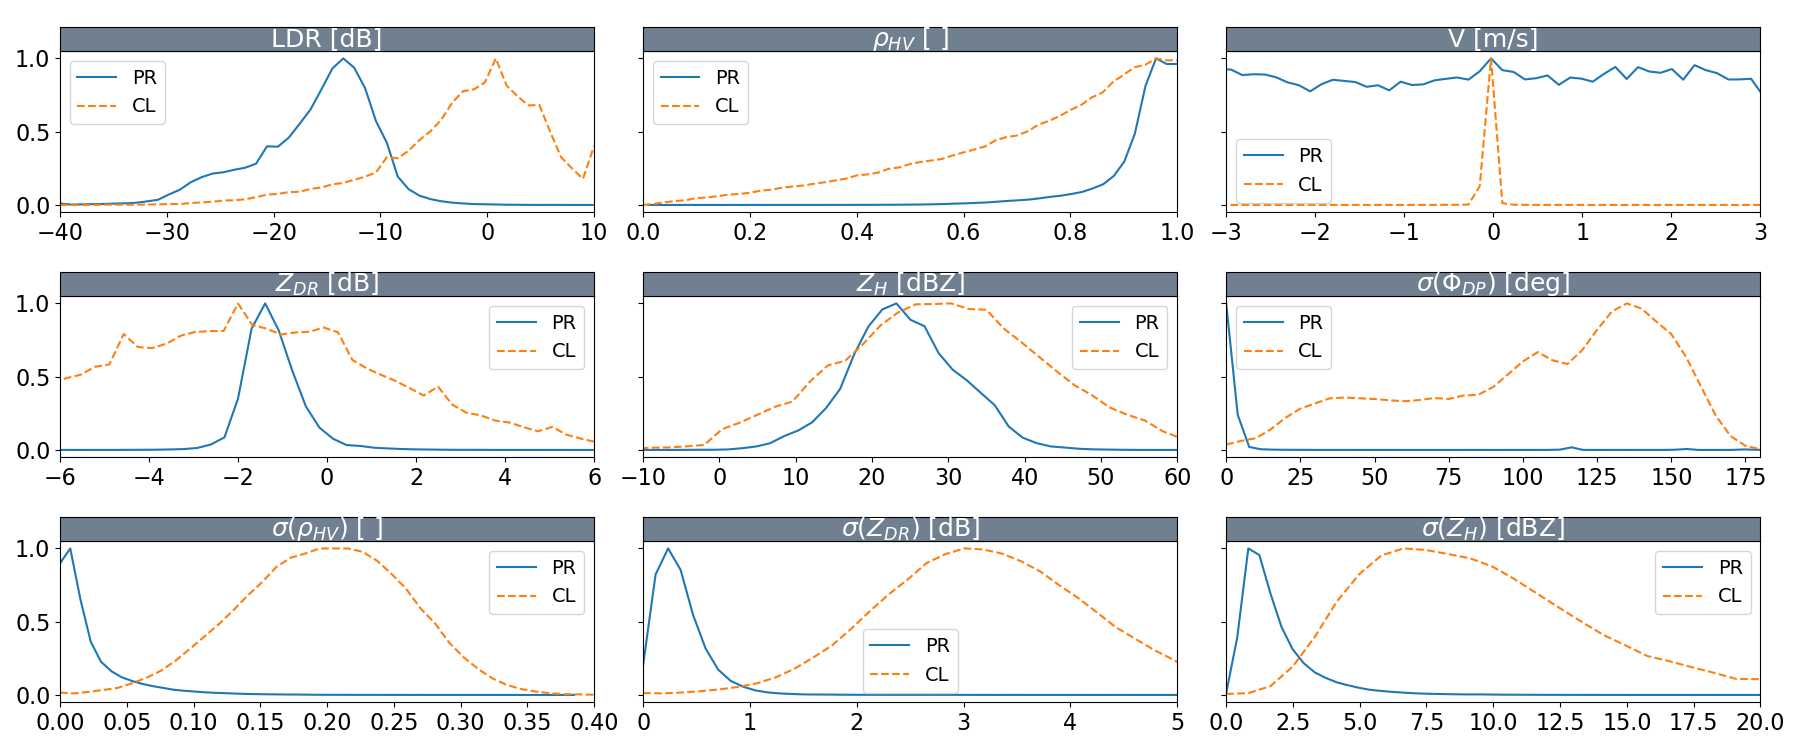

In [14]:
tp.datavis.rad_display.plot_mfs(f'../towerpy/eclass/mfs_cband/') 

## References

Met Office (2003): Met Office Rain Radar Data from the NIMROD System. NCAS British Atmospheric Data Centre, 2022. http://catalogue.ceda.ac.uk/uuid/82adec1f896af6169112d09cc1174499
